In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 03:56:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   32C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6242351179971593
GPU (s):
0.031192671987810172
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.resnet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
234708992/234698864 [==============================] - 191s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 40s 84ms/step - loss: 0.9255 - accuracy: 0.6633 - val_loss: 0.6464 - val_accuracy: 0.7197
Epoch 2/100
360/360 [==============================] - 28s 77ms/step - loss: 0.6722 - accuracy: 0.7220 - val_loss: 0.5947 - val_accuracy: 0.7451
Epoch 3/100
360/360 [==============================] - 27s 74ms/step - loss: 0.6281 - accuracy: 0.7406 - val_loss: 0.5691 - val_accuracy: 0.7539
Epoch 4/100
360/360 [==============================] - 27s 75ms/step - loss: 0.6007 - accuracy: 0.7529 - val_loss: 0.5757 - val_accuracy: 0.7541
Epoch 5/100
360/360 [==============================] - 27s 75ms/step - loss: 0.5858 - accuracy: 0.7598 - val_loss: 0.5547 - val_accuracy: 0.7678
Epoch 6/100
360/360 [================

360/360 [==============================] - 26s 73ms/step - loss: 0.4398 - accuracy: 0.8252 - val_loss: 0.4626 - val_accuracy: 0.8112
Epoch 55/100
360/360 [==============================] - 26s 74ms/step - loss: 0.4362 - accuracy: 0.8271 - val_loss: 0.4646 - val_accuracy: 0.8197
Epoch 56/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4315 - accuracy: 0.8255 - val_loss: 0.4671 - val_accuracy: 0.8159
Epoch 57/100
360/360 [==============================] - 26s 74ms/step - loss: 0.4342 - accuracy: 0.8261 - val_loss: 0.4658 - val_accuracy: 0.8128
Epoch 58/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4343 - accuracy: 0.8276 - val_loss: 0.4760 - val_accuracy: 0.8084
Epoch 59/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4292 - accuracy: 0.8287 - val_loss: 0.4524 - val_accuracy: 0.8216
Epoch 60/100
360/360 [==============================] - 26s 73ms/step - loss: 0.4324 - accuracy: 0.8320 - val_loss: 0.4700 - val_accuracy

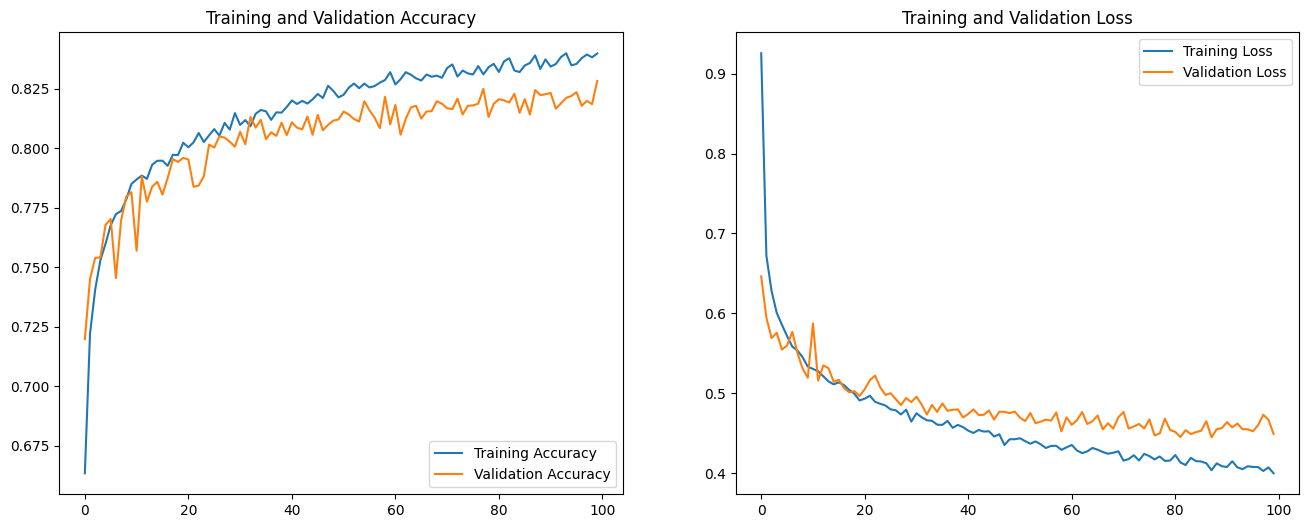

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 39s 80ms/step - loss: 0.9304 - accuracy: 0.6585 - val_loss: 0.6837 - val_accuracy: 0.6971
Epoch 2/100
360/360 [==============================] - 28s 78ms/step - loss: 0.6775 - accuracy: 0.7160 - val_loss: 0.6292 - val_accuracy: 0.7428
Epoch 3/100
360/360 [==============================] - 27s 74ms/step - loss: 0.6439 - accuracy: 0.7331 - val_loss: 0.6316 - val_accuracy: 0.7313
Epoch 4/100
360/360 [==============================] - 27s 74ms/step - loss: 0.6177 - accuracy: 0.7422 - val_loss: 0.5805 - val_accuracy: 0.7516
Epoch 5/100
360/360 [==============================] - 27s 74ms/step - loss: 0.6094 - accuracy: 0.7491 - val_loss: 0.5969 - val_accuracy: 0.7522
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 0.5935 - accuracy: 0.7555 - val_loss: 0.5673 - va

360/360 [==============================] - 27s 74ms/step - loss: 0.4477 - accuracy: 0.8177 - val_loss: 0.4964 - val_accuracy: 0.8006
Epoch 57/100
360/360 [==============================] - 26s 73ms/step - loss: 0.4565 - accuracy: 0.8168 - val_loss: 0.4798 - val_accuracy: 0.8147
Epoch 58/100
360/360 [==============================] - 26s 73ms/step - loss: 0.4604 - accuracy: 0.8130 - val_loss: 0.4958 - val_accuracy: 0.8088
Epoch 59/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4515 - accuracy: 0.8190 - val_loss: 0.4805 - val_accuracy: 0.8123
Epoch 60/100
360/360 [==============================] - 26s 73ms/step - loss: 0.4563 - accuracy: 0.8145 - val_loss: 0.4909 - val_accuracy: 0.8039
Epoch 61/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4516 - accuracy: 0.8175 - val_loss: 0.5050 - val_accuracy: 0.7972
Epoch 62/100
360/360 [==============================] - 26s 73ms/step - loss: 0.4529 - accuracy: 0.8172 - val_loss: 0.4869 - val_accuracy

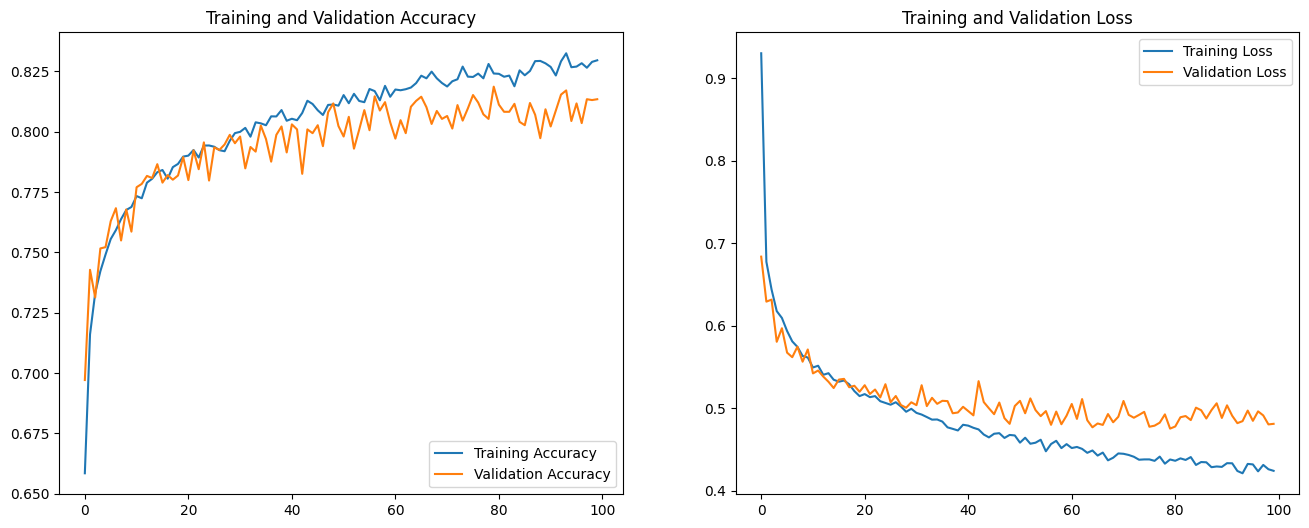

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 38s 80ms/step - loss: 0.7061 - accuracy: 0.7258 - val_loss: 0.4921 - val_accuracy: 0.8038
Epoch 2/100
360/360 [==============================] - 27s 74ms/step - loss: 0.5220 - accuracy: 0.7835 - val_loss: 0.4731 - val_accuracy: 0.8025
Epoch 3/100
360/360 [==============================] - 28s 77ms/step - loss: 0.4851 - accuracy: 0.7991 - val_loss: 0.4758 - val_accuracy: 0.8104
Epoch 4/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4673 - accuracy: 0.8094 - val_loss: 0.4166 - val_accuracy: 0.8376
Epoch 5/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4464 - accuracy: 0.8169 - val_loss: 0.4058 - val_accuracy: 0.8361
Epoch 6/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4385 - accuracy: 0.8233 - v

360/360 [==============================] - 27s 75ms/step - loss: 0.3234 - accuracy: 0.8706 - val_loss: 0.3192 - val_accuracy: 0.8730
Epoch 58/100
360/360 [==============================] - 26s 74ms/step - loss: 0.3219 - accuracy: 0.8719 - val_loss: 0.3273 - val_accuracy: 0.8767
Epoch 59/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3221 - accuracy: 0.8734 - val_loss: 0.3304 - val_accuracy: 0.8746
Epoch 60/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3201 - accuracy: 0.8745 - val_loss: 0.3327 - val_accuracy: 0.8729
Epoch 61/100
360/360 [==============================] - 26s 74ms/step - loss: 0.3200 - accuracy: 0.8729 - val_loss: 0.3208 - val_accuracy: 0.8819
Epoch 62/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3197 - accuracy: 0.8735 - val_loss: 0.3322 - val_accuracy: 0.8746
Epoch 63/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3210 - accuracy: 0.8725 - val_loss: 0.3217 - val_accuracy

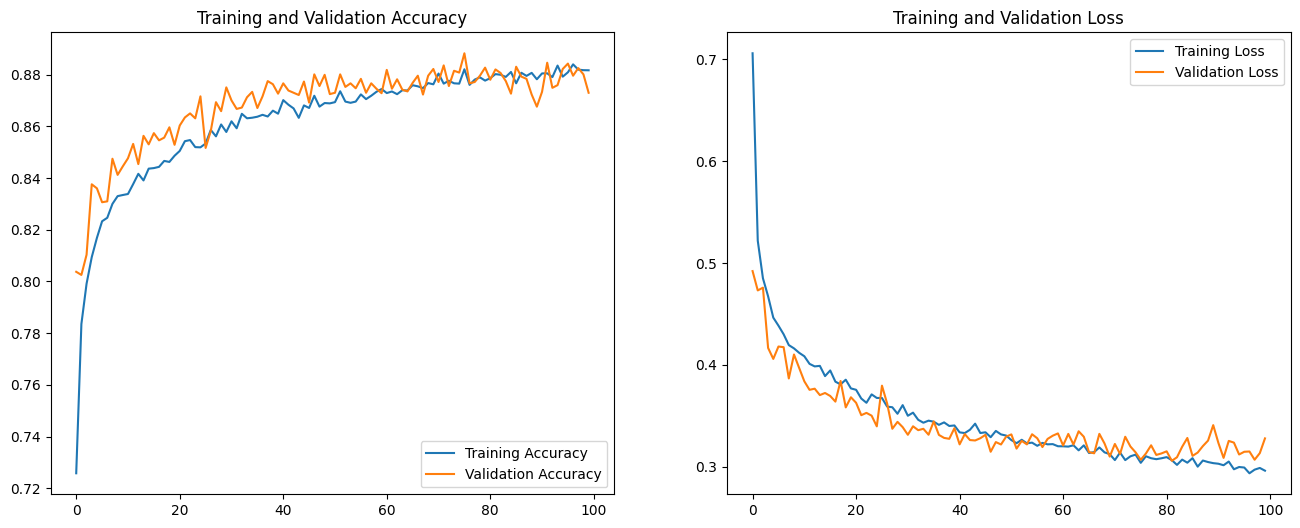

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 38s 81ms/step - loss: 0.6649 - accuracy: 0.7430 - val_loss: 0.4420 - val_accuracy: 0.8208
Epoch 2/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4891 - accuracy: 0.7985 - val_loss: 0.4401 - val_accuracy: 0.8095
Epoch 3/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4654 - accuracy: 0.8092 - val_loss: 0.4007 - val_accuracy: 0.8350
Epoch 4/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4407 - accuracy: 0.8174 - val_loss: 0.3931 - val_accuracy: 0.8402
Epoch 5/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4298 - accuracy: 0.8283 - val_loss: 0.4003 - val_accuracy: 0.8435
Epoch 6/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4170 - accuracy: 0.8310 - val_loss: 0.3839 - va

360/360 [==============================] - 26s 73ms/step - loss: 0.3123 - accuracy: 0.8777 - val_loss: 0.2997 - val_accuracy: 0.8817
Epoch 57/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3142 - accuracy: 0.8761 - val_loss: 0.2985 - val_accuracy: 0.8856
Epoch 58/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3078 - accuracy: 0.8775 - val_loss: 0.2926 - val_accuracy: 0.8871
Epoch 59/100
360/360 [==============================] - 26s 74ms/step - loss: 0.3069 - accuracy: 0.8792 - val_loss: 0.3070 - val_accuracy: 0.8836
Epoch 60/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3117 - accuracy: 0.8764 - val_loss: 0.2998 - val_accuracy: 0.8829
Epoch 61/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3031 - accuracy: 0.8796 - val_loss: 0.3046 - val_accuracy: 0.8836
Epoch 62/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3040 - accuracy: 0.8807 - val_loss: 0.2978 - val_accuracy

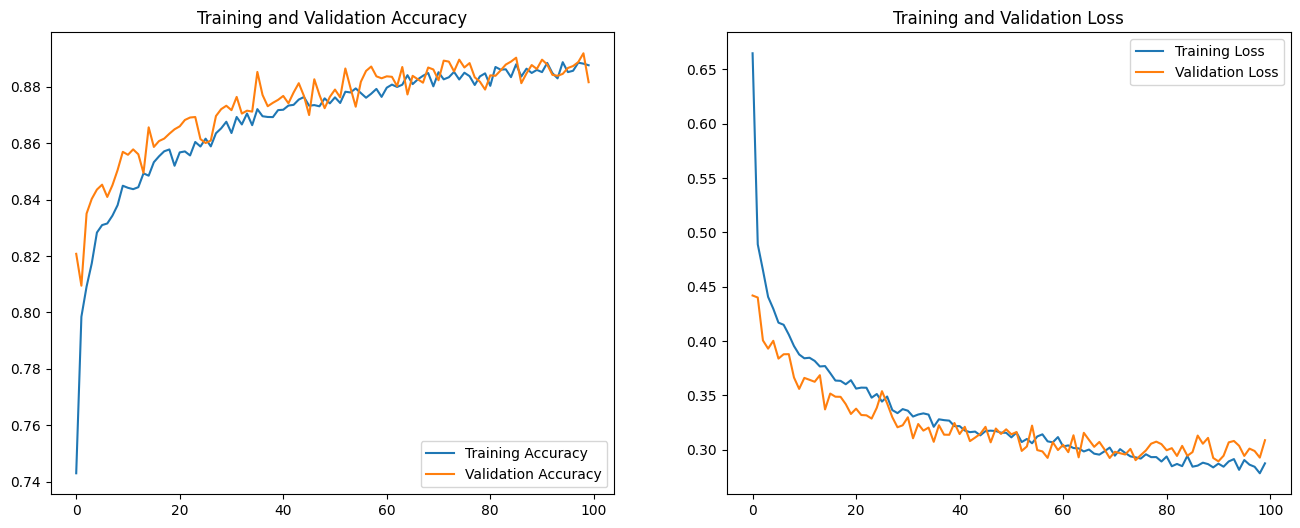

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 38s 80ms/step - loss: 0.7263 - accuracy: 0.7099 - val_loss: 0.5388 - val_accuracy: 0.7695
Epoch 2/100
360/360 [==============================] - 27s 75ms/step - loss: 0.5665 - accuracy: 0.7604 - val_loss: 0.5100 - val_accuracy: 0.7873
Epoch 3/100
360/360 [==============================] - 26s 74ms/step - loss: 0.5232 - accuracy: 0.7839 - val_loss: 0.4826 - val_accuracy: 0.7970
Epoch 4/100
360/360 [==============================] - 26s 74ms/step - loss: 0.5139 - accuracy: 0.7843 - val_loss: 0.4969 - val_accuracy: 0.7888
Epoch 5/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4996 - accuracy: 0.7925 - val_loss: 0.4566 - val_accuracy: 0.8064
Epoch 6/100
360/360 [==============================] - 27s 74ms/step - loss: 0.4857 - accuracy: 0.7975 - v

360/360 [==============================] - 27s 74ms/step - loss: 0.3590 - accuracy: 0.8550 - val_loss: 0.3670 - val_accuracy: 0.8536
Epoch 57/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3660 - accuracy: 0.8543 - val_loss: 0.3685 - val_accuracy: 0.8513
Epoch 58/100
360/360 [==============================] - 26s 74ms/step - loss: 0.3668 - accuracy: 0.8543 - val_loss: 0.3693 - val_accuracy: 0.8522
Epoch 59/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3621 - accuracy: 0.8546 - val_loss: 0.3622 - val_accuracy: 0.8560
Epoch 60/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3617 - accuracy: 0.8540 - val_loss: 0.3739 - val_accuracy: 0.8466
Epoch 61/100
360/360 [==============================] - 26s 74ms/step - loss: 0.3663 - accuracy: 0.8537 - val_loss: 0.3547 - val_accuracy: 0.8579
Epoch 62/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3601 - accuracy: 0.8548 - val_loss: 0.3615 - val_accuracy

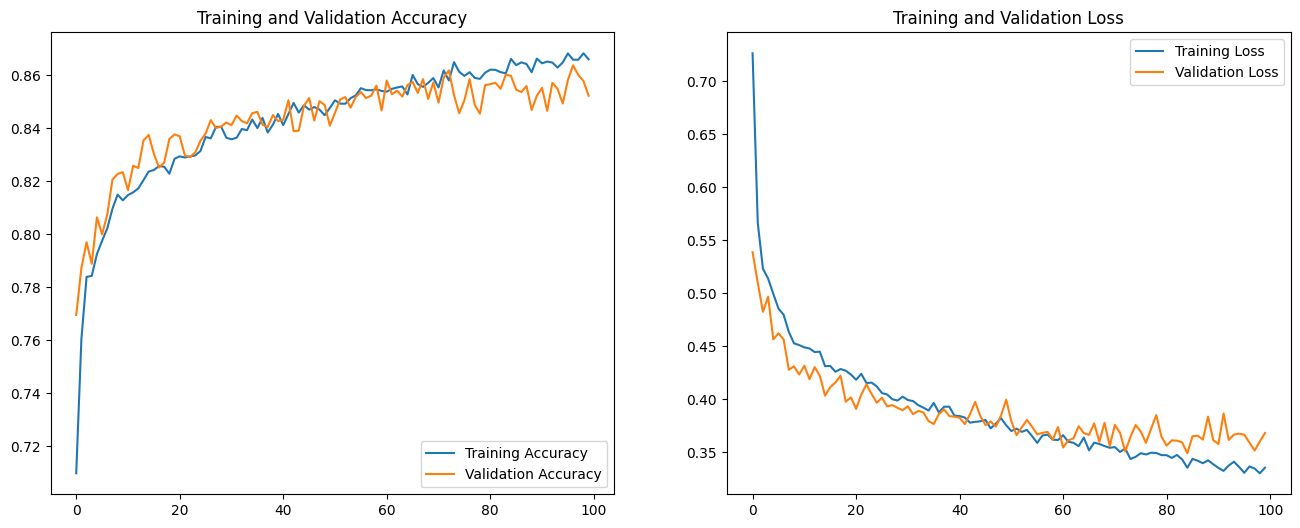

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 38s 80ms/step - loss: 0.6838 - accuracy: 0.7217 - val_loss: 0.5780 - val_accuracy: 0.7619
Epoch 2/100
360/360 [==============================] - 28s 77ms/step - loss: 0.5512 - accuracy: 0.7632 - val_loss: 0.4804 - val_accuracy: 0.8022
Epoch 3/100
360/360 [==============================] - 27s 74ms/step - loss: 0.5152 - accuracy: 0.7826 - val_loss: 0.4595 - val_accuracy: 0.8112
Epoch 4/100
360/360 [==============================] - 27s 76ms/step - loss: 0.5000 - accuracy: 0.7861 - val_loss: 0.4725 - val_accuracy: 0.7970
Epoch 5/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4829 - accuracy: 0.7945 - val_loss: 0.4451 - val_accuracy: 0.8201
Epoch 6/100
360/360 [==============================] - 26s 73ms/step - loss: 0.4763 - accuracy: 0.7985 - val_loss: 0.4270 - va

360/360 [==============================] - 26s 73ms/step - loss: 0.3482 - accuracy: 0.8593 - val_loss: 0.3699 - val_accuracy: 0.8571
Epoch 57/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3491 - accuracy: 0.8580 - val_loss: 0.3645 - val_accuracy: 0.8609
Epoch 58/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3487 - accuracy: 0.8574 - val_loss: 0.3560 - val_accuracy: 0.8631
Epoch 59/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3448 - accuracy: 0.8599 - val_loss: 0.3552 - val_accuracy: 0.8604
Epoch 60/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3511 - accuracy: 0.8596 - val_loss: 0.3606 - val_accuracy: 0.8651
Epoch 61/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3425 - accuracy: 0.8639 - val_loss: 0.3595 - val_accuracy: 0.8642
Epoch 62/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3512 - accuracy: 0.8557 - val_loss: 0.3612 - val_accuracy

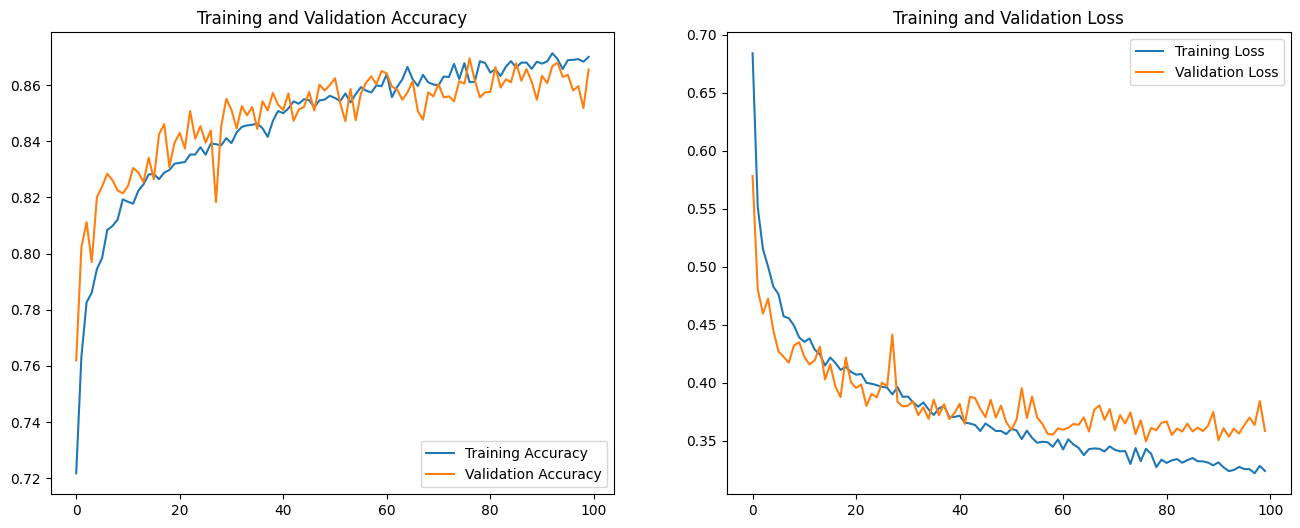

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("resnet152_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("resnet152_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("resnet152_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("resnet152_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("resnet152_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("resnet152_nontrainable/res_ycrcb_nonpre.csv", index=False)